<a href="https://colab.research.google.com/github/Manvi1718/FER_XAI/blob/main/xgradcam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as model
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
from PIL import Image
import os
import cv2

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define transformations, including grayscale and augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Path to the root directory of your train and test data in Google Drive
test_data_path = '/content/drive/MyDrive/pytorch/ck+/CK+48 splitted/test_d'
train_data_path = '/content/drive/MyDrive/pytorch/ck+/CK+48 splitted/train_d'

# List of emotion labels
emotion_labels = [
    'anger', 'contempt', 'disgust', 'fear', 'happiness', 'sadness', 'surprise'
]


class CustomDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.image_paths = [os.path.join(root, filename) for filename in os.listdir(root) if filename.endswith(".png")]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path)

        if self.transform:
            image = self.transform(image)

        # Manually extract the emotion label from the filename
        emotion_label = image_path.split('/')[-1].split('_')[0]

        # Handle variations in emotion labels
        if emotion_label == 'happy':
            emotion_label = 'happiness'

        # Get the label index from the emotion_labels list
        label = emotion_labels.index(emotion_label)

        return image, label
# Load your custom train and test datasets
train_dataset = CustomDataset(train_data_path, transform=transform)
test_dataset = CustomDataset(test_data_path, transform=transform)

# Create DataLoaders
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



In [ ]:
import torchvision.models as model
dir(model)

['AlexNet',
 'AlexNet_Weights',
 'ConvNeXt',
 'ConvNeXt_Base_Weights',
 'ConvNeXt_Large_Weights',
 'ConvNeXt_Small_Weights',
 'ConvNeXt_Tiny_Weights',
 'DenseNet',
 'DenseNet121_Weights',
 'DenseNet161_Weights',
 'DenseNet169_Weights',
 'DenseNet201_Weights',
 'EfficientNet',
 'EfficientNet_B0_Weights',
 'EfficientNet_B1_Weights',
 'EfficientNet_B2_Weights',
 'EfficientNet_B3_Weights',
 'EfficientNet_B4_Weights',
 'EfficientNet_B5_Weights',
 'EfficientNet_B6_Weights',
 'EfficientNet_B7_Weights',
 'EfficientNet_V2_L_Weights',
 'EfficientNet_V2_M_Weights',
 'EfficientNet_V2_S_Weights',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'GoogLeNet_Weights',
 'Inception3',
 'InceptionOutputs',
 'Inception_V3_Weights',
 'MNASNet',
 'MNASNet0_5_Weights',
 'MNASNet0_75_Weights',
 'MNASNet1_0_Weights',
 'MNASNet1_3_Weights',
 'MaxVit',
 'MaxVit_T_Weights',
 'MobileNetV2',
 'MobileNetV3',
 'MobileNet_V2_Weights',
 'MobileNet_V3_Large_Weights',
 'MobileNet_V3_Small_Weights',
 'RegNet',
 'RegNet_X_16GF_Weights'

In [ ]:
# Load ResNet50 model
resnet50_model = model.resnet50(pretrained=False)
resnet50_model.fc = nn.Linear(resnet50_model.fc.in_features, 7)  # Set the number of classes
resnet50_state_dict = torch.load('/content/drive/MyDrive/Emotion_Analysis_Model/ResNet50.pth')
resnet50_model.eval()
resnet50_model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-37-5ed1c4ed52a8>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
class XGradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradient = None
        self.activations = None
        self.hook_layers()

    def hook_layers(self):
        def forward_hook(module, input, output):
            self.activations = output
        def backward_hook(module, grad_in, grad_out):
            self.gradient = grad_out[0]
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate_cam(self, input_tensor, target_class):
        # Forward pass to get the output
        output = self.model(input_tensor) # Getting output from model

        # Backprop to the target class
        self.model.zero_grad()
        target = output[:, target_class].sum() # Using the output of the model
        target.backward(retain_graph=True)

        # Compute weights and CAM
        weights = F.adaptive_avg_pool2d(self.gradient, 1)
        cam = torch.sum(weights * self.activations, dim=1).squeeze()

        # Detach cam from the computation graph before converting to NumPy array
        cam = torch.clamp(cam, min=0).cpu().detach().numpy()

        # Normalize CAM
        cam = (cam - cam.min()) / (cam.max() - cam.min())
        return cam

In [ ]:
# Transformation pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
target_layer = resnet50_model.layer4[2]
xgrad_cam = XGradCAM(resnet50_model, target_layer)

In [ ]:
# Image folder path
image_folder = '/content/drive/MyDrive/FER_Images'

emotion_images = ['anger', 'contempt', 'disgust', 'fear', 'happiness', 'sadness', 'surprise']
results = {}

for emotion in emotion_images:
    img_path = os.path.join(image_folder, f"{emotion}.png")
    img = Image.open(img_path).convert('RGB')
    input_tensor = transform(img).unsqueeze(0).to(device)
    target_class = emotion_labels.index(emotion)
    # Get EigenGradCAM heatmap
    xgrad_cam_map = xgrad_cam.generate_cam(input_tensor,target_class)

    # Convert the original and heatmap to numpy for plotting
    original_img = np.array(img.resize((224, 224)))
    heatmap = cv2.applyColorMap(np.uint8(255 * xgrad_cam_map), cv2.COLORMAP_INFERNO)
    heatmap = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0])) # Resize heatmap
    heatmap_overlay = cv2.addWeighted(original_img, 0.6, heatmap, 0.4, 0)
    # Store images for visualization
    results[emotion] = (original_img, heatmap_overlay, heatmap)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


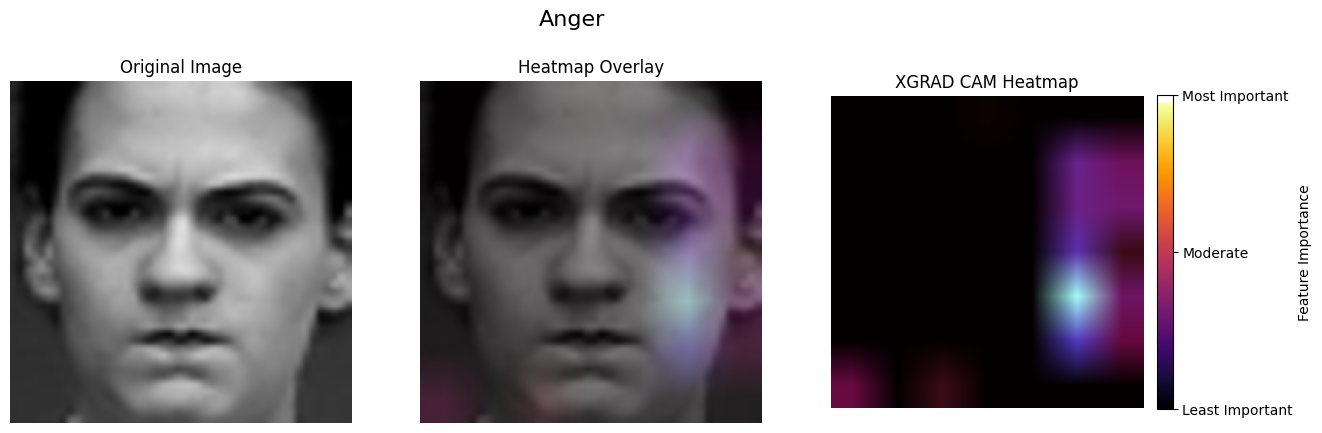

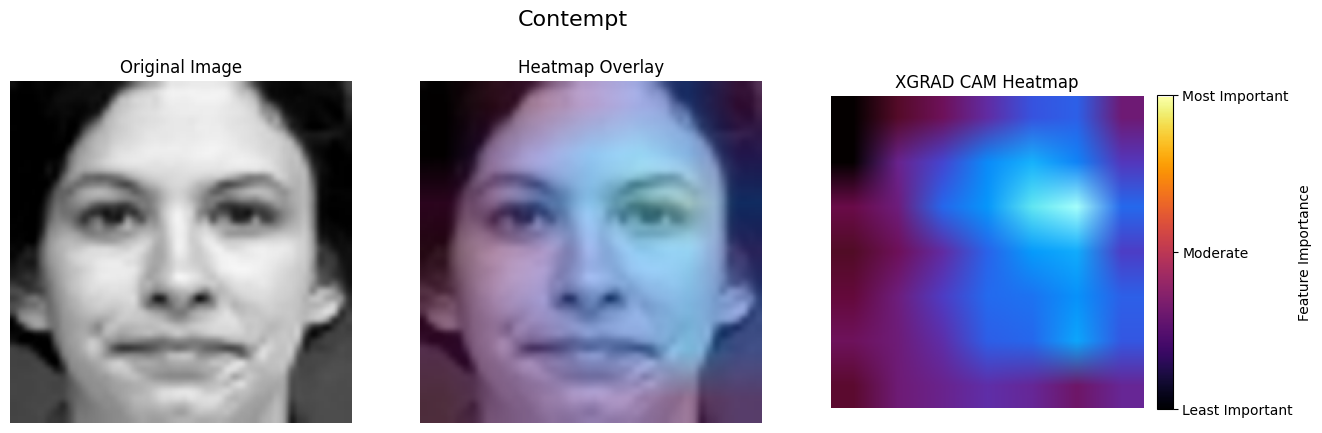

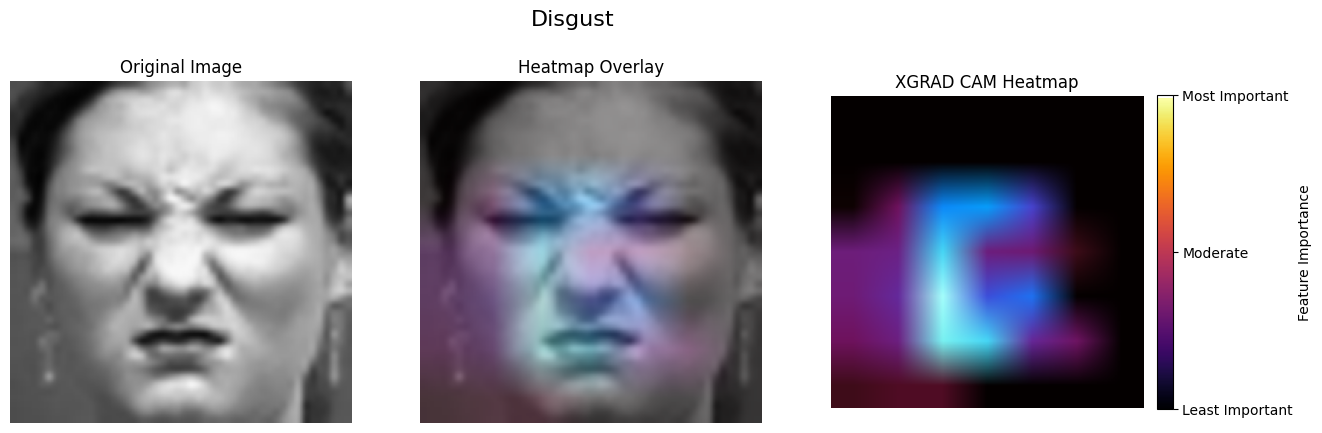

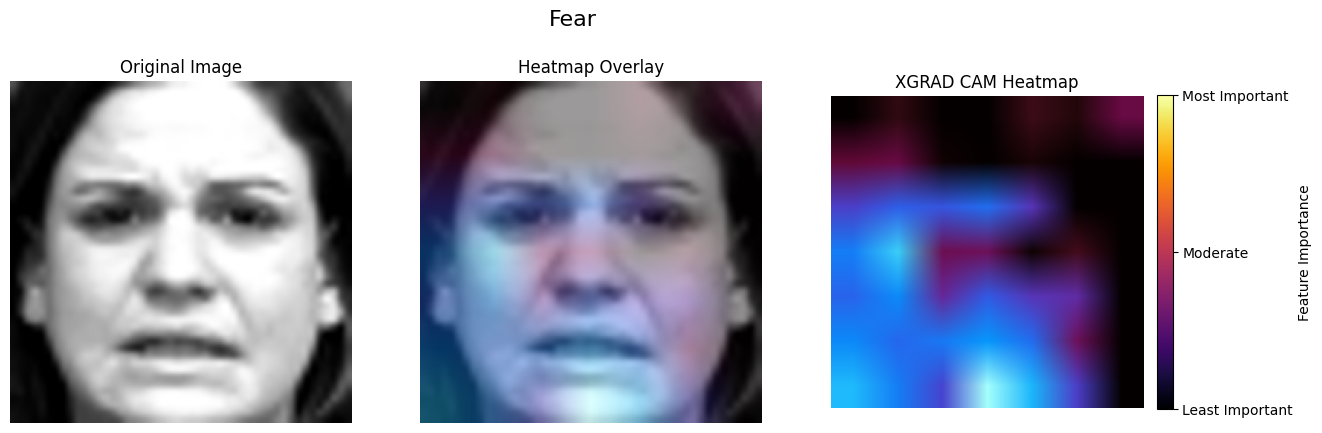

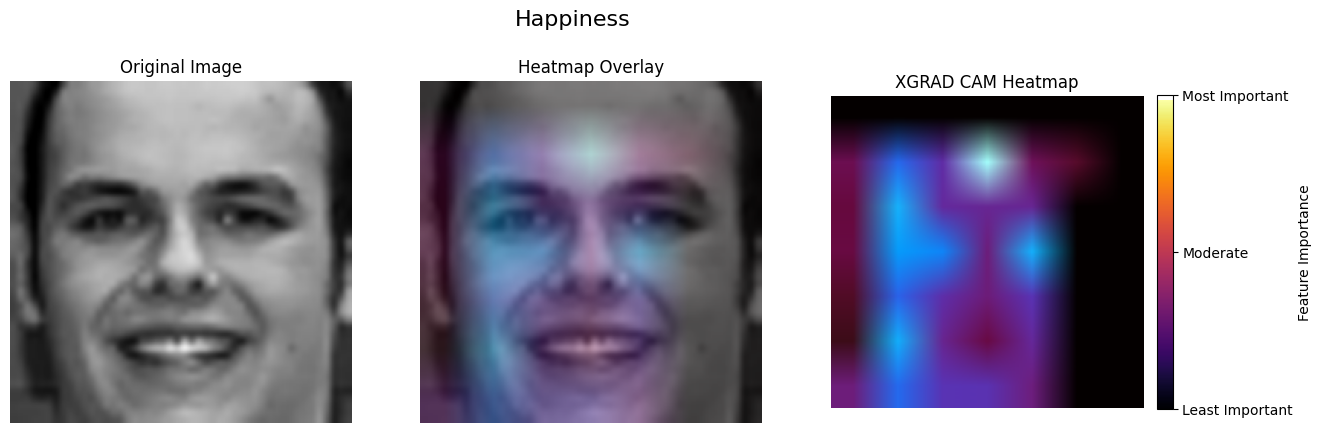

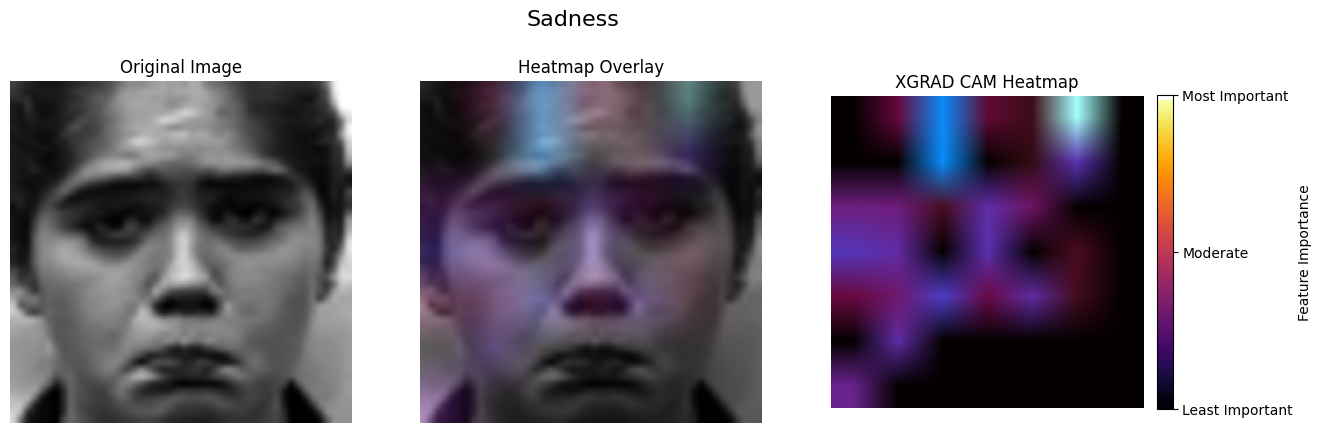

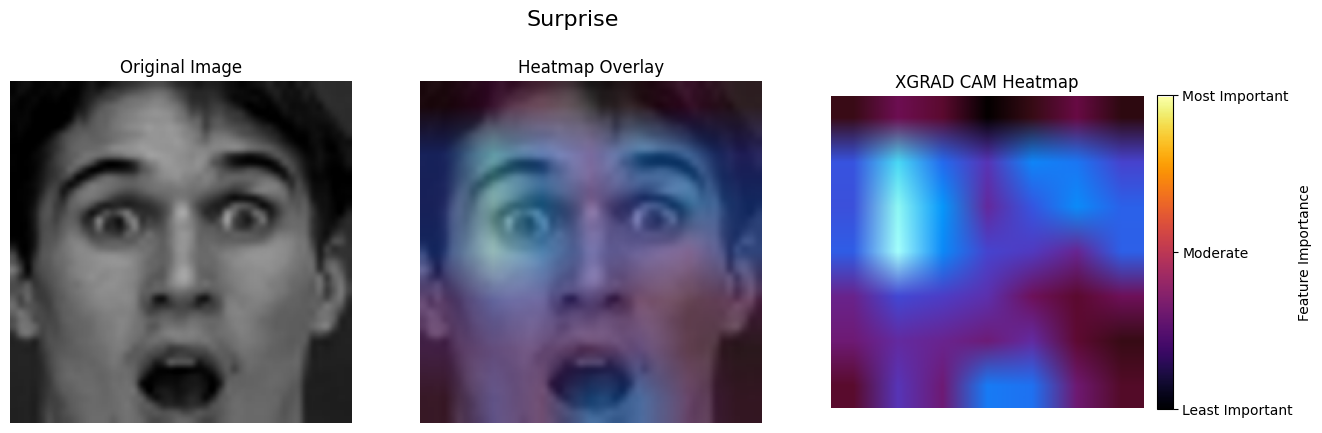

In [ ]:
# Plotting with colorbar
for emotion, (original_img, heatmap_overlay, heatmap) in results.items():
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(emotion.capitalize(), fontsize=16)

    # Original Image
    ax[0].imshow(original_img)
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    # Heatmap Overlay
    ax[1].imshow(heatmap_overlay)
    ax[1].set_title('Heatmap Overlay')
    ax[1].axis('off')

    # Standalone Heatmap with Colorbar (using 'inferno' colormap)
    heatmap_img = ax[2].imshow(heatmap, cmap='inferno')
    ax[2].set_title('XGRAD CAM Heatmap')
    ax[2].axis('off')

    # Add colorbar matching the 'inferno' colormap
    cbar = fig.colorbar(heatmap_img, ax=ax[2], fraction=0.046, pad=0.04)
    cbar.set_label('Feature Importance')
    cbar.set_ticks([0, 127.5, 255])
    cbar.set_ticklabels(['Least Important', 'Moderate', 'Most Important'])

    plt.show()